In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

os.environ['NUMBAPRO_CUDALIB']=r"C:\Users\hyli93\Miniconda3\envs\py3gpu\Library\bin"
sys.path.append('C:/Users/hyli93/Documents/GitHub/Phasing/')
display(HTML("<style>.container { width:95% !important; }</style>"))

from phase import gpualgorithms
from phase import testutil


# Load pattern

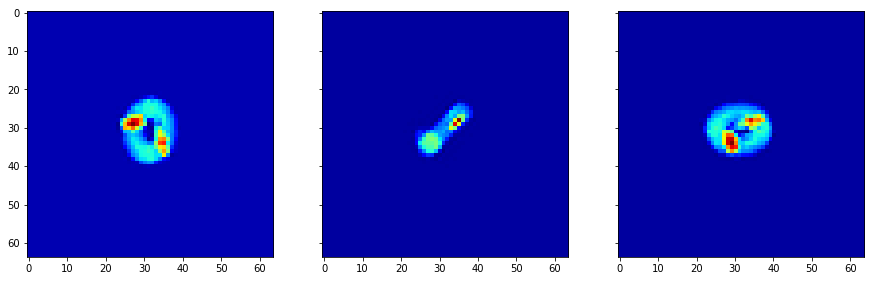

In [2]:
# Generate a dumb bell
sphere1= testutil.get_ellipsoid(2,3,4, 20,20,20)*2
sphere2= testutil.get_ellipsoid(4,2,1, 20,20,20)*5
torus1 = testutil.get_torus(6,3,20,20,20)

tmp = testutil.shift(sphere1, -4,-4,-1) + testutil.shift(sphere2, 4,2,1) + torus1
tmp = testutil.rotate(tmp, 23,45,92)

sample = np.zeros((64, 64, 64)) 
sample[21:41, 21:41, 21:41] = tmp

## Show this object
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,5))
ax1.imshow(np.sum(sample,axis=0), cmap='jet')
ax2.imshow(np.sum(sample,axis=1), cmap='jet')
ax3.imshow(np.sum(sample,axis=2), cmap='jet')

# Get Diffraction intensity and the mask

In [3]:
# Calculate the fourier transformation
fourier_pattern_complete = np.fft.ifftshift(np.fft.fftn(sample))
fourier_pattern = np.copy(fourier_pattern_complete)

# Add beam stop effect
r_stop = 3  # Radius of the beam stop
fourier_pattern[40 - r_stop: 40 + r_stop,
                40 - r_stop: 40 + r_stop,
                40 - r_stop: 40 + r_stop] = 0

#Show this mask and the diffraction magnitude
magnitude = np.abs(fourier_pattern)

#keep track of where the image is vs the padding
length, width, height = sample.shape
#keep track of where the image is vs the padding
mask_float = np.zeros_like(sample, dtype=np.int64)
mask_float[21:41, 21:41, 21:41] = 1

mask_bool = np.zeros_like(mask_float)
mask_bool[mask_float>=0.5] = True

# Get mask in reciprocal space with boolean values
reciprocal_mask_bool = np.ones_like(fourier_pattern, dtype=np.bool)
reciprocal_mask_bool[:,:] = True
reciprocal_mask_bool[40 - r_stop: 40 + r_stop,
                     40 - r_stop: 40 + r_stop,
                     40 - r_stop: 40 + r_stop] = False



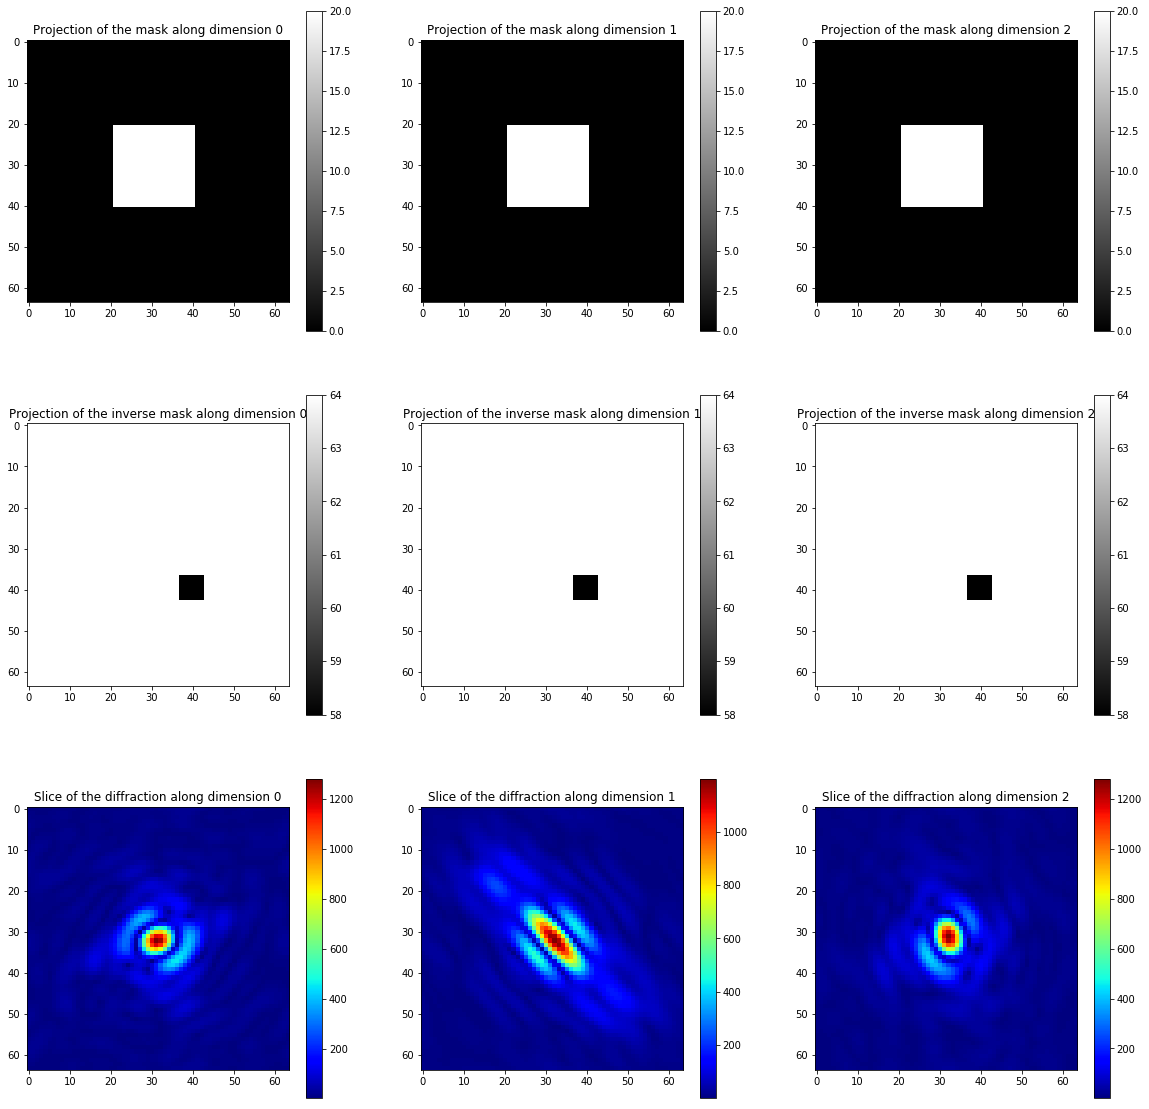

The image size is 64 by 64 by 64


In [4]:
fig, axes = plt.subplots(ncols=3, nrows=3)
fig.set_figwidth(20)
fig.set_figheight(20)

for l in range(3):
    ax = axes[0, l]
    tmp = ax.imshow(np.sum(mask_float, axis=l), cmap='gray')
    ax.set_title("Projection of the mask along dimension {}".format(l))
    fig.colorbar(mappable=tmp, ax=ax)
    
for l in range(3):
    ax = axes[1, l]
    tmp = ax.imshow(np.sum(reciprocal_mask_bool, axis=l), cmap='gray')
    ax.set_title("Projection of the inverse mask along dimension {}".format(l))
    fig.colorbar(mappable=tmp, ax=ax)
    
    
slices = [magnitude[31,:,:],
          magnitude[:,31,:],
          magnitude[:,:,31]]
for l in range(3):
    ax = axes[2, l]
    tmp = ax.imshow(slices[l], cmap='jet')
    ax.set_title("Slice of the diffraction along dimension {}".format(l))
    fig.colorbar(mappable=tmp, ax=ax)
    
plt.show()
print("The image size is %d by %d by %d"%(mask_bool.shape[0], mask_bool.shape[1], mask_bool.shape[2]))

# Begin the calculation

In [5]:
result = gpualgorithms.apply_3d_hio_with_wrap_shrink(magnitude_constrain=np.fft.fftshift(magnitude),
                                                     support_bool = np.fft.fftshift(mask_bool),
                                                     reciprocal_mask = np.fft.fftshift(reciprocal_mask_bool)
                                                    )

It takes 6.43 seconds to do 1000 iterations.


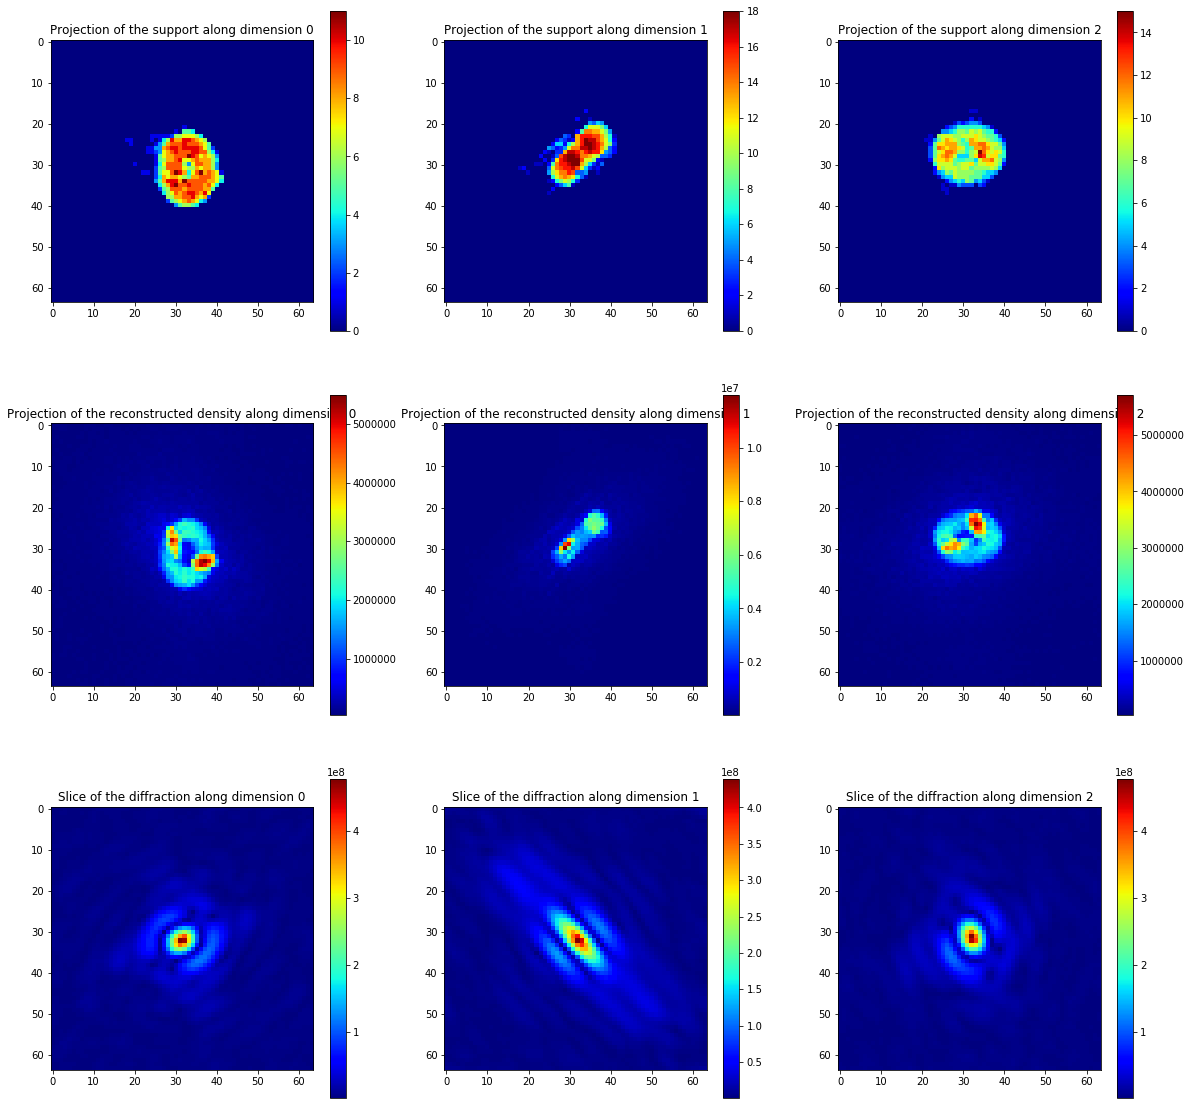

The image size is 64 by 64 by 64


In [6]:
fig, axes = plt.subplots(ncols=3, nrows=3)
fig.set_figwidth(20)
fig.set_figheight(20)

for l in range(3):
    ax = axes[0, l]
    tmp = ax.imshow(np.sum(np.fft.ifftshift(result['Final Support']), axis=l), cmap='jet')
    ax.set_title("Projection of the support along dimension {}".format(l))
    fig.colorbar(mappable=tmp, ax=ax)
    
for l in range(3):
    ax = axes[1, l]
    tmp = ax.imshow(np.sum(np.fft.ifftshift(result['Reconstructed Density']), axis=l), cmap='jet')
    ax.set_title("Projection of the reconstructed density along dimension {}".format(l))
    fig.colorbar(mappable=tmp, ax=ax)
    
    
tmp = np.fft.ifftshift(result['Reconstructed Magnitude Field'])
slices = [tmp[31,:,:],
          tmp[:,31,:],
          tmp[:,:,31]]
for l in range(3):
    ax = axes[2, l]
    tmp = ax.imshow(slices[l], cmap='jet')
    ax.set_title("Slice of the diffraction along dimension {}".format(l))
    fig.colorbar(mappable=tmp, ax=ax)
    
plt.show()
print("The image size is %d by %d by %d"%(mask_bool.shape[0], mask_bool.shape[1], mask_bool.shape[2]))

In [7]:
from pyculib import fft as pfft


In [55]:
phase = np.exp(1j*np.random.rand(64,64,64)*2*np.pi)
field = np.multiply(magnitude, phase) + np.random.rand(64,64,64)*10

In [56]:
fft_gpu = np.zeros((64,64,64), dtype=np.complex128)
pfft.ifft(field, fft_gpu)

fft_cpu = np.fft.ifftn(field)

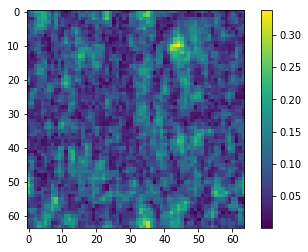

In [57]:
plt.imshow(np.abs(fft_cpu[31]))
plt.colorbar()
plt.show()

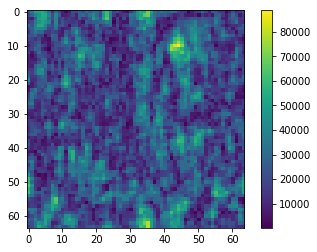

In [58]:
plt.imshow(np.abs(fft_gpu[31]))
plt.colorbar()
plt.show()

In [59]:
np.std(np.abs(fft_gpu/fft_cpu))

2.3658650900943692e-10

In [60]:
np.mean(np.abs(fft_gpu/fft_cpu))

262144.0